In [9]:
import uproot	
import numpy as np
import matplotlib.pyplot as plt
import pylab
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
from methods.fit_linear_regression_model import fit_linear_regression_model
import sklearn
%matplotlib inline

In [10]:
file = uproot.open(
    "tracking_losses_ntuple_B_default_radlength_beginVelo.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1"
)

# selektiere nur elektronen von B->K*ee
allcolumns = file.arrays()
found = allcolumns[
    (allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromB)
]  # B: 9056
lost = allcolumns[
    (allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromB)
]  # B: 1466

electrons = allcolumns[(allcolumns.isElectron) & (allcolumns.fromB)]

print(ak.num(found, axis=0), ak.num(lost, axis=0))
print(ak.num(electrons, axis=0))
# ak.count(found, axis=None)

40402 10099
50501


In [11]:
rad_length_found = ak.to_numpy(found["rad_length_frac"])
eta_found = ak.to_numpy(found["eta"])
phi_found = ak.to_numpy(found["phi"])

rad_length_lost = ak.to_numpy(lost["rad_length_frac"])
eta_lost = ak.to_numpy(lost["eta"])
phi_lost = ak.to_numpy(lost["phi"])

stretch_factor = ak.num(eta_lost, axis=0) / ak.num(eta_found, axis=0)
print("stretch factor: ", stretch_factor)

stretch factor:  0.24996287312509283


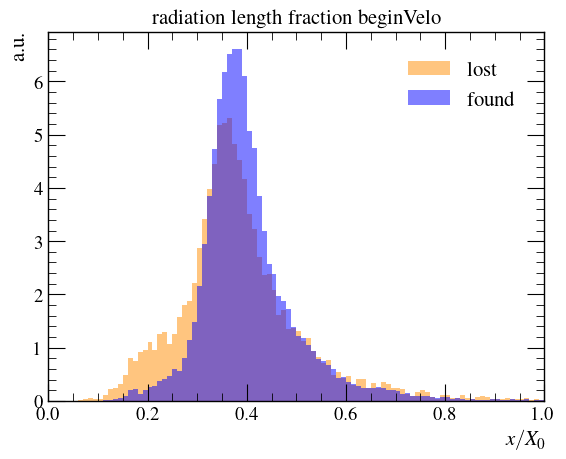

In [12]:
plt.hist(
    rad_length_lost,
    bins=100,
    density=True,
    alpha=0.5,
    color="darkorange",
    histtype="bar",
    label="lost",
    range=[0, 1],
)
plt.hist(
    rad_length_found,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    label="found",
    range=[0, 1],
)
plt.xlim(0, 1)
# plt.yscale("log")
plt.title("radiation length fraction beginVelo")
plt.xlabel(f"$x/X_0$")
plt.ylabel("a.u.")

plt.legend()
plt.show()

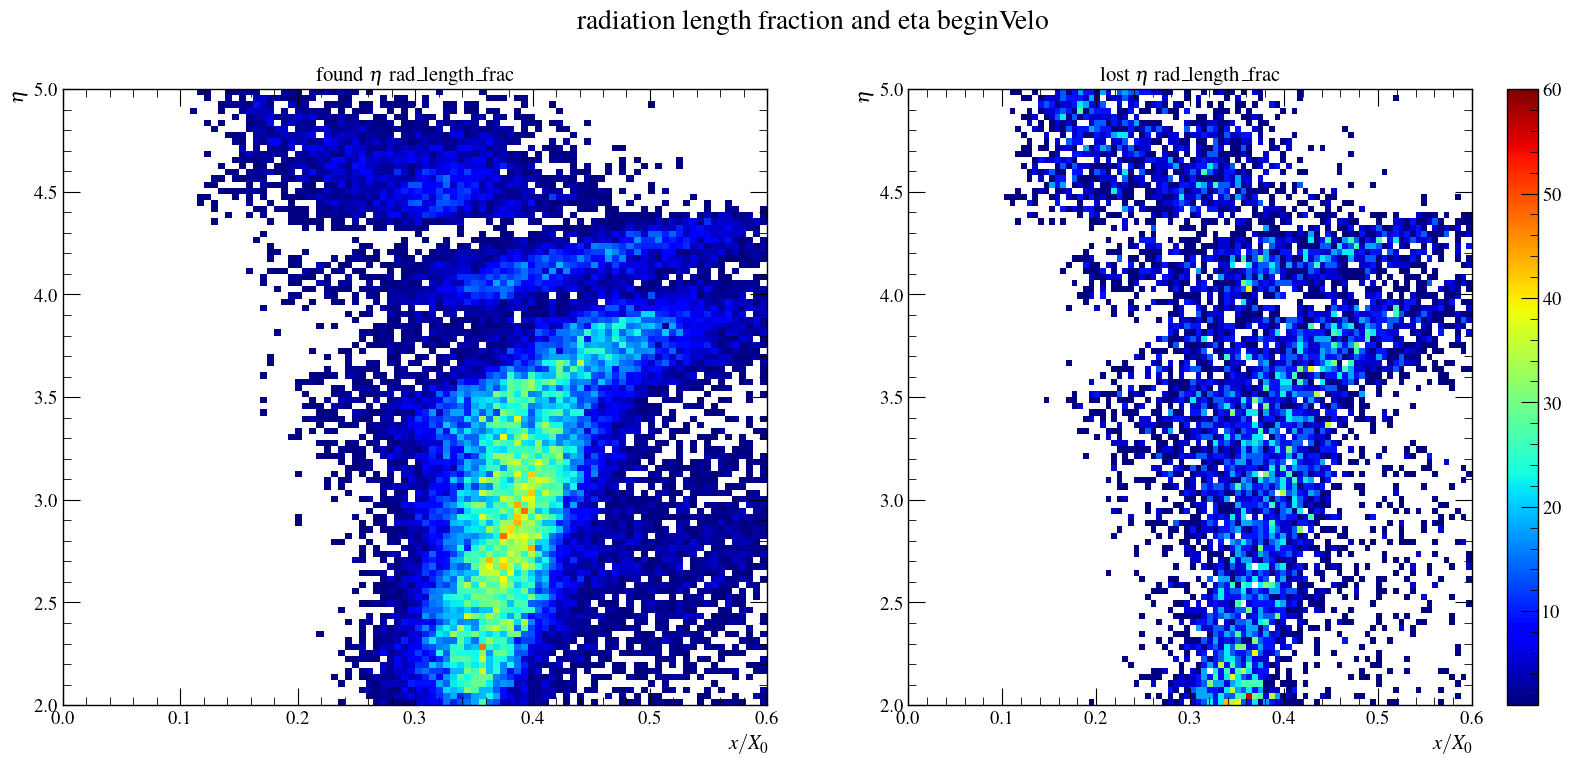

In [13]:
nbins = 100
vmax = 60

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

a0 = ax0.hist2d(
    rad_length_found,
    eta_found,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[0, 0.6], [2, 5]],
)
ax0.set_xlabel(f"$x/X_0$")
ax0.set_ylabel(f"$\eta$")
ax0.set_title(f"found $\eta$ rad_length_frac")

a1 = ax1.hist2d(
    rad_length_lost,
    eta_lost,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[0, 0.6], [2, 5]],
)
ax1.set_xlabel(f"$x/X_0$")
ax1.set_ylabel(f"$\eta$")
ax1.set_title(f"lost $\eta$ rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.suptitle("radiation length fraction and eta beginVelo")
plt.colorbar(a0[3], ax=ax1)

plt.show()

Parameterisation for rad_length_frac:
intercept= 0.0
coef= {'1': 0.4397780582886272, 'x': -0.00033503537608265674, 'y': -4.789321464958182e-05, 'tx': 0.29235639572920724, 'ty': 0.04582618208302177, 'qop': -6.415064049320476, 'x^2': -1.7148780985188313e-05, 'x y': 6.213092137729638e-05, 'x tx': 0.0357792373581695, 'x ty': -0.03383507316198001, 'x qop': 5.411983741236269, 'y^2': -0.0001816058133305051, 'y tx': -0.060157737422332554, 'y ty': 0.3005860193729231, 'y qop': -0.5258168180545822, 'tx^2': -20.581151289333324, 'tx ty': 33.044369657406456, 'tx qop': -4029.9409136973454, 'ty^2': -125.62371943789807, 'ty qop': 353.08874965548245, 'qop^2': -3.455196781164501, 'x^3': 1.5371780097645036e-07, 'x^2 y': -1.2426481494632311e-06, 'x^2 tx': -0.0003102207951011151, 'x^2 ty': 0.0008294673378711963, 'x^2 qop': -0.0013130710648701907, 'x y^2': 1.3249247615395102e-07, 'x y tx': 0.0018733641082853674, 'x y ty': 0.0011459295349262105, 'x y qop': 0.0019703515773188207, 'x tx^2': 0.20678893428535178,

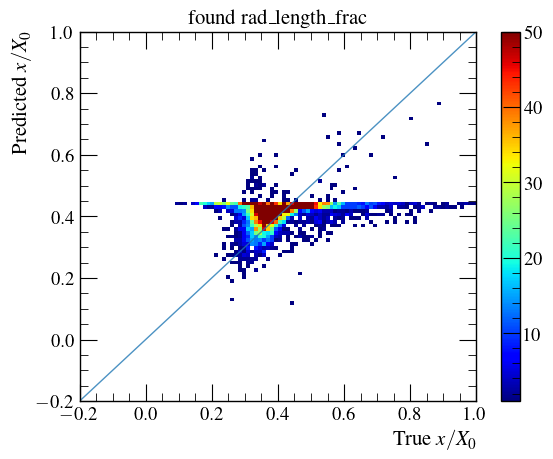

In [14]:
rad_length_frac = found["rad_length_frac"]
# @ z = 9400.mm or 770.mm
state = 1

if state == 1:
    slopex = found["ideal_state_770_tx"]
    slopey = found["ideal_state_770_ty"]
    x = found["ideal_state_770_x"]
    y = found["ideal_state_770_y"]
    qop = found["ideal_state_770_qop"]
elif state == 2:
    slopex = found["ideal_state_9410_tx"]
    slopey = found["ideal_state_9410_ty"]
    x = found["ideal_state_9410_x"]
    y = found["ideal_state_9410_y"]
    qop = found["ideal_state_9410_qop"]

data = ak.zip({
    "rad_length_frac": rad_length_frac,
    "x": x,
    "y": y,
    "tx": slopex,
    "ty": slopey,
    "qop": qop,
})
lin_reg, features, xx0_test, xx0_predicted = fit_linear_regression_model(
    data,
    "rad_length_frac",
    ["x", "y", "tx", "ty", "qop"],
    4,
    include_bias=True,
)
nbins = 100
vmax = 50

a0 = plt.hist2d(
    xx0_test,
    xx0_predicted,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[-0.2, 1.0], [-0.2, 1.0]],
)
plt.plot([-0.2, 1], [-0.2, 1], marker="", alpha=0.8)
plt.xlabel(f"True $x/X_0$")
plt.ylabel(f"Predicted $x/X_0$")
plt.title(f"found rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.colorbar(a0[3])
plt.show()

Parameterisation for rad_length_frac:
intercept= 0.0
coef= {'1': 0.4479234646536249, 'x': -0.0004084072172278079, 'y': -0.0004337281522268355, 'tx': 0.36162738714391346, 'ty': 0.3074416852772706, 'qop': 8.6879246998874, 'x^2': 6.870638463563449e-05, 'x y': -0.00012148333505099224, 'x tx': -0.08753632946361847, 'x ty': -0.008841630356866574, 'x qop': 2.3636302084612413, 'y^2': -0.00010231235440107948, 'y tx': 0.18497450621593262, 'y ty': 0.1675559125761048, 'y qop': -4.153708925054445, 'tx^2': 23.782917176875543, 'tx ty': -66.05577891519296, 'tx qop': -1451.879997584788, 'ty^2': -72.70407315466386, 'ty qop': 2811.440565472475, 'qop^2': 25.48376520289995, 'x^3': 3.312211575601438e-06, 'x^2 y': 4.1376174463449524e-06, 'x^2 tx': -0.007073302591271084, 'x^2 ty': -0.007343778680981201, 'x^2 qop': -0.010800896868279859, 'x y^2': -1.888730589918227e-06, 'x y tx': -0.0015500723141160817, 'x y ty': 0.003351080332733322, 'x y qop': -0.01735357445380728, 'x tx^2': 4.990549905339206, 'x tx ty': 7.5

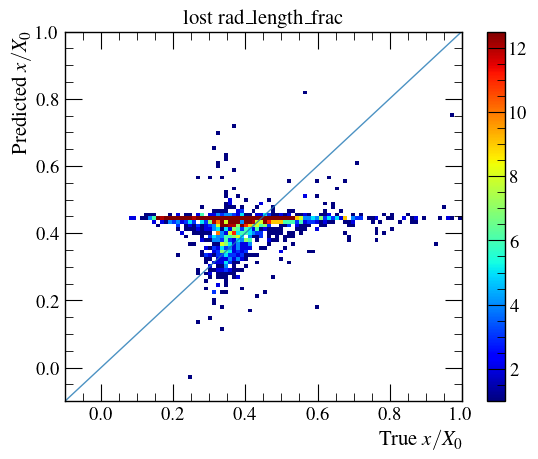

In [17]:
rad_length_frac = lost["rad_length_frac"]
# @ z = 9400.mm or 770.mm
state = 1

if state == 1:
    slopex = lost["ideal_state_770_tx"]
    slopey = lost["ideal_state_770_ty"]
    x = lost["ideal_state_770_x"]
    y = lost["ideal_state_770_y"]
    qop = lost["ideal_state_770_qop"]
elif state == 2:
    slopex = lost["ideal_state_9410_tx"]
    slopey = lost["ideal_state_9410_ty"]
    x = lost["ideal_state_9410_x"]
    y = lost["ideal_state_9410_y"]
    qop = lost["ideal_state_9410_qop"]

data = ak.zip({
    "rad_length_frac": rad_length_frac,
    "x": x,
    "y": y,
    "tx": slopex,
    "ty": slopey,
    "qop": qop,
})
lin_reg, features, xx0_test, xx0_predicted = fit_linear_regression_model(
    data,
    "rad_length_frac",
    ["x", "y", "tx", "ty", "qop"],
    4,
    include_bias=True,
)

nbins = 100
vmax = 50

a0 = plt.hist2d(
    xx0_test,
    xx0_predicted,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[-0.1, 1.0], [-0.1, 1.0]],
)
plt.plot([-0.1, 1], [-0.1, 1], marker="", alpha=0.8)
plt.xlabel(f"True $x/X_0$")
plt.ylabel(f"Predicted $x/X_0$")
plt.title(f"lost rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.colorbar(a0[3])
plt.show()

In [ ]:
test = ak.zip({
    "tx": slopex,
    "ty": slopey,
    "x": x,
    "y": y,
    "qop": qop,
})
test = np.column_stack([ak.to_numpy(test[feat]) for feat in features])